<a href="https://colab.research.google.com/github/Yeongseok-Kim/PytorchClassReview/blob/master/gender_classificater.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare dataset
본 코드에 사용된 데이터셋은 [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)의 처음 3만 개 이미지를 남성과 여성으로 분류한 데이터셋이다.  
80%에 해당하는 2만 4천 개 이미지를 트레이닝셋으로, 20%에 해당하는 6천 개 이미지를 테스트셋으로 사용하였다.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!unzip '/content/drive/My Drive/gender_classification.zip'

In [0]:
import torch
import os
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.dataset import Dataset
from PIL import Image



class MyDataset(Dataset):
    def __init__(self, female_dir, male_dir):
        self.female_list = [female_dir + file_name for file_name in os.listdir(female_dir)]
        self.male_list = [male_dir + file_name for file_name in os.listdir(male_dir)]
        self.transforms = transforms.Compose([transforms.CenterCrop((128, 128)),
                                              transforms.Resize((64, 64)),
                                              transforms.ToTensor(),
                                              transforms.Normalize((.5, .5, .5), (.5, .5, .5))])
    
    def __len__(self):
        return len(self.female_list + self.male_list)
    
    def __getitem__(self, index):
        female_len = len(self.female_list)
        if index < female_len:
            img = Image.open(self.female_list[index])
            label = torch.zeros(1)
        else:
            img = Image.open(self.male_list[index - female_len])
            label = torch.ones(1)
        img = self.transforms(img)
        return img, label

#Model

In [0]:
import torch.nn as nn



class Classificater(nn.Module):
    def __init__(self):
        super(Classificater, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(256, 512, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(512, 1024, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2))
        
        self.fc = nn.Sequential(
            nn.Linear(1024 * 2 * 2, 1),
            nn.Sigmoid())
        
    def forward(self, x):
        out = self.layer(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

#Training

In [0]:
import torch.optim as optim
from torch.utils.data import DataLoader



if __name__ == '__main__':
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    batch_size = 64
    train_data = MyDataset('/content/train_set/female/', '/content/train_set/male/')
    train_set = DataLoader(train_data, batch_size, True)

    test_batch = 64
    test_data = MyDataset('/content/test_set/female/', '/content/test_set/male/')
    test_set = DataLoader(test_data, test_batch, True)

    learning_rate = 0.0002
    training_epochs = 20

    net = Classificater().to(device)
    criterion = nn.BCELoss().to(device)
    optimizer = optim.Adam(net.parameters(), learning_rate)

    print('Learning started. it takes sometime.')

    for epoch in range(1, training_epochs + 1):
        for img, label in train_set:
            batch_size = img.size(0)

            img = img.to(device)
            label = label.to(device)

            optimizer.zero_grad()
            hypothesis = net(img)
            cost = criterion(hypothesis, label)

            cost.backward()
            optimizer.step()

            print("epoch %d train cost: %f" % (epoch, cost.item()))

        print('epoch %d is over.' % epoch)

        if epoch % 10 == 0:
            with torch.no_grad():
                for img, label in test_set:
                    test_batch = img.size(0)

                    img = img.to(device)
                    label = label.to(device)

                    prediction = net(img)
                    cost = criterion(prediction, label)

                    print("epoch %d test cost: %f" % (epoch, cost.item()))
            
            torch.save(net.state_dict(), './gender_classificater_epoch_%d.pth' % epoch)
    
    print('Learning Finished.')

#Result

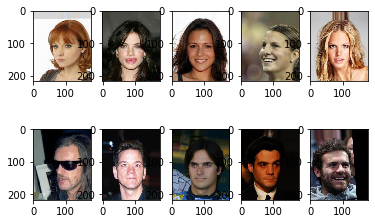

0.007584
0.000000
0.000000
0.000164
0.000000
0.999937
0.998794
0.999999
1.000000
1.000000


In [14]:
import random
from matplotlib import pyplot as plt
import matplotlib.image as mpimg



transforms = transforms.Compose([transforms.CenterCrop((128, 128)),
                                 transforms.Resize((64, 64)),
                                 transforms.ToTensor(),
                                 transforms.Normalize((.5, .5, .5), (.5, .5, .5))])

if __name__ == '__main__':
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    net = Classificater().to(device)

    load_net = './gender_classificater_epoch_20.pth'
    net.load_state_dict(torch.load(load_net))

    with torch.no_grad():
        female_dir = '/content/test_set/female/'
        male_dir = '/content/test_set/male/'

        female_list = [female_dir + file_name for file_name in os.listdir(female_dir)]
        male_list = [male_dir + file_name for file_name in os.listdir(male_dir)]

        random.shuffle(female_list)
        random.shuffle(male_list)

        imgs = female_list[:5] + male_list[:5]

        fig = plt.figure()

        ax = []
        for i in range(1, 11):
            ax.append(fig.add_subplot(2, 5, i))
        
        for i in range(10):
            show_img = mpimg.imread(imgs[i])
            ax[i].imshow(show_img)
        
        plt.show()

        for img in imgs:
            test_img = Image.open(img)
            test_img = transforms(test_img).to(device)

            prediction = net(test_img.unsqueeze(0))

            print("%f" % prediction)